In [28]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from train import test1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()
import seaborn as sns

import os
import cv2

In [29]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.7')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [30]:
DATA_PATH = '/home/mmorocho/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/mmorocho/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value' 
        #'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime'
       ]
test_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv', usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan','mmorocho')
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan','mmorocho')
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan','mmorocho')
new_valid = pd.concat([test_df,val_df],ignore_index=False)
train_df.shape, test_df.shape, val_df.shape,new_valid.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
new_valid.reset_index(names='unique_key',inplace=True)

train_df = train_df.to_numpy()
new_valid = new_valid.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

(21374, 2) (2602, 2) (2692, 2)
(15164, 4) (1823, 4) (1913, 4)


In [31]:
#from zmq import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df[idx,:]
        #plt.imshow(im,cmap='gray')
        #plt.show()
        #returns image, bnpp value log, binary variable for edema
        
        #resnet
        return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]
    
        #vgg?
        #return torch.load(row[4]).view(1, 224, 224), row[1], row[3]

In [32]:
batch_size = 16 #maybe change to 16, 8
num_workers = 2
pin_memory = True
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = PreprocessedImageDataset(df=val_df) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))
#len(valid_set)
test_set = PreprocessedImageDataset(df=test_df)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

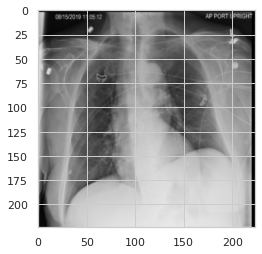

In [33]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = 'ResNet'
if model == 'VGG16':
    model = VGG('VGG16').to(device)
elif model == 'ResNet':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model.to(device)
model

cuda


Using cache found in /home/mmorocho/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


In [9]:
os.environ['NUM_GPU']='1'

In [10]:

# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 1
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
#     tlosses.append(avg_tloss)
#     vlosses.append(avg_vloss)
    tlosses = np.append(tlosses,avg_tloss)
    vlosses = np.append(vlosses,avg_vloss)
    print(tlosses)

    epoch_number += 1
    scheduler.step(avg_vloss)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

EPOCH 1:


100%|██████████| 120/120 [00:07<00:00, 15.54it/s]

LOSS train 0.6027384816077457 valid 0.5178706502082575
[0.60273848]


In [11]:
#loss on unseen test set
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model, loss_fn, test_loader)
print(test_loss)

  1%|▏         | 23/1823 [00:00<00:50, 35.88it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (

0.5227696851763028


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


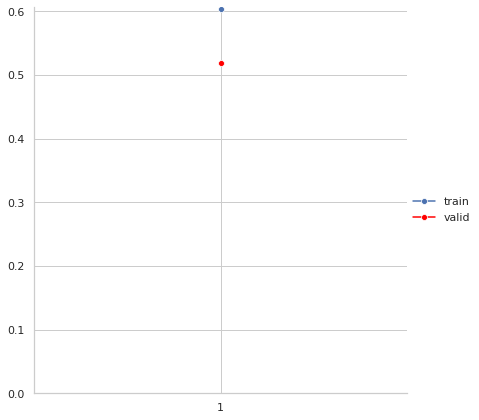

In [12]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### VGG SECTION

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model2 = 'VGG16'
if model2 == 'VGG16':
    model2 = VGG('VGG16').to(device)
elif model2 == 'ResNet':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model2.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model2.to(device)
model2

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxP

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model2.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model2.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 27,514,413 total parameters.
[INFO]: 27,514,413 trainable parameters.


In [10]:
# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 1
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses2, vlosses2 = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model2.parameters():
        param.requires_grad = True
    avg_tloss2 = train1Epoch(epoch_number, model2, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model2.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss2 = test1Epoch(epoch_number, model2, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss2, avg_vloss2))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
    tlosses2 = np.append(tlosses2,avg_tloss2)
    vlosses2 = np.append(vlosses2,avg_vloss2)

    epoch_number += 1
    scheduler.step(avg_vloss2)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

EPOCH 1:


 56%|█████▌    | 67/120 [00:02<00:02, 23.63it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (functio

LOSS train 0.8128860023807462 valid 0.6200272225943488


In [11]:
#loss on unseen test set
for param in model2.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model2, loss_fn, test_loader)
print(test_loss)

 29%|██▉       | 527/1823 [00:02<00:05, 229.61it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (fu

0.6125038363581752


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


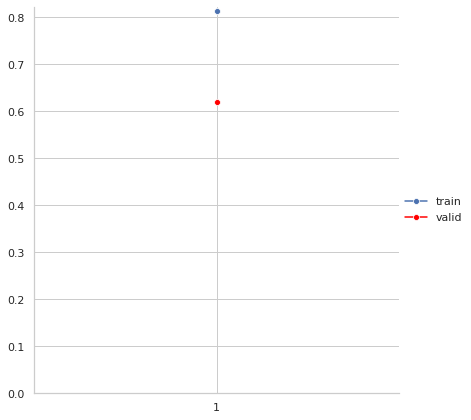

In [12]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses2,'valid loss':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses2,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

In [13]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss resnet': tlosses,'valid loss resnet':vlosses, 'train loss vgg': tlosses2,'valid loss vgg':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='resnet train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='resnet valid')
g = g.map(sns.lineplot, x=epochs,y=tlosses2,color='green',marker='o', label='vgg16 train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='orange',marker='o', label='vgg16 valid')

g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

NameError: name 'tlosses' is not defined

### Resnet AUC work

In [20]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model(image)
            hearts = np.append(hearts, heart)
            #preds = np.append(preds, pred.item())
            preds = np.append(preds, pred.cpu())

100%|██████████| 1823/1823 [00:53<00:00, 34.38it/s]


In [22]:
preds

array([1.97779703, 2.29186916, 3.14629197, ..., 1.86729145, 2.30496478,
       3.56419635])

In [23]:
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()

In [24]:
np.power(10,np.log10(400))/(np.power(10,preds)).sum()

7.451659767267997e-05

In [25]:
y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
y_preds.sum()

1252

In [26]:
hearts

array([1., 0., 1., ..., 0., 1., 1.])

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts, y_preds,normalize='true')
print(cf_mat_norm)

accuracy score: 0.7591881513987931

TN: 415
FP: 283
FN: 156
TP: 969

Confusion matrix
[[415 283]
 [156 969]]

[[0.59455587 0.40544413]
 [0.13866667 0.86133333]]


### VGG16 AUC Work

In [ ]:
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2, hearts2 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model2(image)
            hearts2 = np.append(hearts2, heart)
            #preds = np.append(preds, pred.item())
            preds2 = np.append(preds2, pred.cpu())

In [ ]:
prob_preds2 = np.power(10,preds2) / (np.power(10,preds2)).sum()

In [ ]:
np.power(10,np.log10(400))/(np.power(10,preds2)).sum()

In [ ]:
y_preds2 = prob_preds2 > (np.power(10,np.log10(400))/(np.power(10,preds2)).sum())
y_preds2.sum()

In [ ]:
hearts2

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts2, y_preds2)}')
tn, fp, fn, tp = confusion_matrix(hearts2, y_preds2).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts2, y_preds2)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts2, y_preds2,normalize='true')
print(cf_mat_norm)

In [14]:
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxP

In [15]:
gradients = model2.get_activations_gradient()

In [16]:
gradients

In [17]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

TypeError: mean() received an invalid combination of arguments - got (NoneType, dim=list), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


### Combined AUC Curves

In [33]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [42]:
#plot_roc_curve(hearts, y_preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, y_preds)}')

In [43]:
#plot_roc_curve(hearts, preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, prob_preds)}')

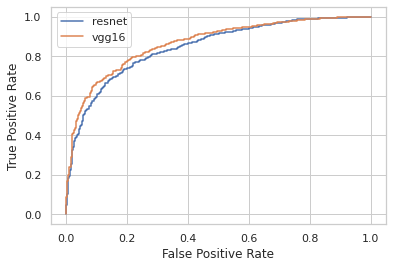

In [41]:
plot_roc_curve(hearts2,preds2)
plot_roc_curve(hearts,preds)
plt.gca().legend(('resnet','vgg16'))

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

In [85]:
valid_set[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0705, 0.0740, 0.0752,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0626, 0.0538, 0.0444,  ..., 0.0000, 0.0000, 0.0000],
          [0.0630, 0.0525, 0.0455,  ..., 0.0000, 0.0000, 0.0000],
          [0.0607, 0.0523, 0.0474,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0705, 0.0740, 0.0752,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0626, 0.0538, 0.0444,  ..., 0.0000, 0.0000, 0.0000],
          [0.0630, 0.0525, 0.0455,  ..., 0.0000, 0.0000, 0.0000],
          [0.0607, 0.0523, 0.0474,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0705, 0.0740, 0.0752,  ...,

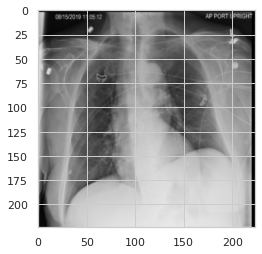

In [34]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

In [39]:
test1 = valid_set[0][0].unsqueeze(0)

In [45]:
import argparse


In [66]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument('--use-cuda', action='store_true', default=False)
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=['gradcam'])
    parser.add_argument(
        '--image-path',
        type=str,
        default='./examples/both.png',
        help='Input image path')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    

    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args


# if __name__ == '__main__':
#     """ python cam.py -image-path <path_to_image>
#     Example usage of loading an image, and computing:
#         1. CAM
#         2. Guided Back Propagation
#         3. Combining both
#     """
args = get_args()

Using CPU for computation


In [78]:
#rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
rgb_img = np.float32((valid_set[0][0]).T) / 255

/tmp/ipykernel_4894/3979681918.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3493.)
  rgb_img = np.float32((valid_set[0][0]).T) / 255


In [79]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = test1
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)#, use_cuda=args.use_cuda)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [80]:
visualization

array([[[  0,  43, 254],
        [  0,  43, 254],
        [  0,  43, 254],
        ...,
        [  0, 119, 254],
        [  0, 119, 254],
        [  0, 119, 254]],

       [[  0,  43, 254],
        [  0,  43, 254],
        [  0,  43, 254],
        ...,
        [  0, 119, 254],
        [  0, 119, 254],
        [  0, 119, 254]],

       [[  0,  43, 254],
        [  0,  43, 254],
        [  0,  43, 254],
        ...,
        [  0, 119, 254],
        [  0, 119, 254],
        [  0, 119, 254]],

       ...,

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [131,   0,   0],
        [131,   0,   0],
        [131,   0,   0]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [131,   0,   0],
        [131,   0,   0],
        [131,   0,   0]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [131,   0,   0],
        [131,   0,   0],
        [131,   0,   0]]

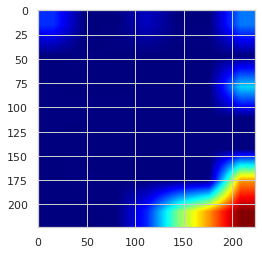

In [84]:
plt.imshow(visualization)